## Build a riverine SFINCS model from scratch

This notebook demonstrates how to prepare **SFINCS** model from scratch using the command line interace (CLI).

All lines in this notebook which start with `!` are executed from the command line. Within the notebook environment the logging messages are shown after completion. You can also copy these lines and paste these in your shell to get more direct feedback.

### hydroMT CLI build interface

Lets first check if the SFINCS model is recognized by hydromt

In [1]:
# this should return "sfincs"
!hydromt --models

hydroMT model plugins: sfincs (v0.2.1.dev0)


Using the **hydromt build** API we can setup a complete model from scratch. Let's get an overview of all the available options:

In [2]:
!hydromt build --help

Usage: hydromt build [OPTIONS] MODEL MODEL_ROOT REGION

  Build models from source data.

  Example usage:
  --------------

  To build a wflow model for a subbasin using and point coordinates snapped to cells with stream order >= 4
  hydromt build wflow /path/to/model_root "{'subbasin': [-7.24, 62.09], 'strord': 4}" -i /path/to/wflow_config.ini

  To build a wflow model based on basin ID
  hydromt build wflow /path/to/model_root "{'basin': 230001006}"

  To build a sfincs model based on a bbox (for Texel)
  hydromt build sfincs /path/to/model_root "{'bbox': [4.6891,52.9750,4.9576,53.1994]}"

Options:
  -r, --res FLOAT             Model resolution in model src.
  --build-base / --build-all  Deprecated!
  --opt TEXT                  Component specific keyword arguments, see the
                              setup_<component> method of the specific model
                              for more information about the arguments.

  -i, --config PATH           Path to hydroMT configuration fi

### setup SFINCS model base layers 

In [3]:
# NOTE: copy this line (without !) to your shell for more direct feedback
!hydromt build sfincs "./sfincs_test_base" "{'bbox': [11.97,45.78,12.28,45.94]}" -r 100 -vv

2021-08-06 09:30:42,130 - build - log - DEBUG - Writing log messages to new file /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_base/hydromt.log.
2021-08-06 09:30:42,130 - build - log - INFO - HydroMT version: 0.4.3.dev
2021-08-06 09:30:42,130 - build - main - INFO - Building instance of sfincs model at /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_base.
2021-08-06 09:30:42,130 - build - main - INFO - User settings:
2021-08-06 09:30:42,133 - build - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1.dev0)
2021-08-06 09:30:42,133 - build - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1.dev0).
2021-08-06 09:30:42,134 - build - model_api - INFO - setup_basemaps.region: {'bbox': [11.97, 45.78, 12.28, 45.94]}
2021-08-06 09:30:42,134 - build - model_api - INFO - setup_basemaps.res: 100.0
2021-08-06 09:30:42,134 - build - model_api - INFO - setup_basemaps.crs: utm
20

2021-08-06 09:30:42,202 - build - data_adapter - INFO - DataCatalog: Getting merit_hydro RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.4/merit_hydro/{variable}.tif


2021-08-06 09:30:42,282 - build - basin_mask - DEBUG - Parsed region (kind=bbox): {'bbox': [11.97, 45.78, 12.28, 45.94]}


2021-08-06 09:30:42,425 - build - model_api - DEBUG - Default config read from /usr/share/miniconda/envs/hydromt-sfincs/lib/python3.9/site-packages/hydromt_sfincs/data/sfincs/sfincs.inp
2021-08-06 09:30:42,425 - build - sfincs - INFO - Write model data to /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_base


2021-08-06 09:30:42,430 - build - sfincs - DEBUG - Write binary map indices based on mask.
2021-08-06 09:30:42,467 - build - sfincs - DEBUG - Write binary map files: ['dep', 'msk'].


2021-08-06 09:30:42,511 - build - sfincs - INFO - Write raster file(s) for staticmaps to 'gis' subfolder


2021-08-06 09:30:42,611 - build - model_api - INFO - Writing model config to /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_base/sfincs.inp


The example above means the following: run **hydromt build** with:

* `sfincs` : i.e. build a sfincs model
* `./sfincs_test_base` : output model folder
* `"{'bbox': [11.97,45.78,12.28,45.94]}"` : make a model that is active for the full given bounding box. All *REGION* options are described in the [docs](https://deltares.github.io/hydromt/latest/user_guide/cli.html#region-options)
* `-r 100` : build the model at a 100 meter resolution
* `-vv` : give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

NOTE: As we did not specify a model configuration, only the base maps (topography) have been setup using default parameters. To build a complete model we need the use a configuraton ini-file.

### Model setup configuration

The ini-file contains the model setup configuration and determines which components are build and in which order and optionally sets non-default arguments for each component. This configuration is passed to hydromt using `-i <path_to_ini_file>`. We have prepared several example ini-files which are available in the model repository [examples folder](https://github.com/Deltares/hydromt_sfincs/tree/main/examples) and from the [docs(build_configuration)](https://deltares.github.io/hydromt_sfincs/latest/user_guide/sfincs/build_configuration.html). 

Each header as shown between `[...]` (e.g. `[setup_basemaps]`) corresponds to a model component. All model components are explained in the [docs(model_components)](https://deltares.github.io/hydromt_sfincs/latest/user_guide/sfincs/components.html). 

We will load the default SFINCS build ini file for inspection:

In [4]:
fn_ini = 'sfincs_riverine.ini'
with open(fn_ini, 'r') as f:
    txt = f.read()
print(txt)

[global]
write_gis = True                # write addtional geotif and geojson files to gis subfolder
config_fn = sfincs.inp          # name of sfincs config (inp) file
artifact_data = True            # load artifact data (snapshot of Deltares data) 

[setup_config]
tref = 20210101 000000
tstart = 20210101 000000
tstop = 20210102 000000
alpha = 0.5
zsini = 0.0
dtmaxout = 86400

[setup_basemaps]
basemaps_fn = merit_hydro       # hydrography basemaps ['elevtn', 'flwdir', 'uparea', 'basins']
crs = utm                       # model CRS (must be UTM zone)

[setup_mask]                    # sets the active cells based on valid dep cells without arguments. required before running setup_river_in/outflow

[setup_cn_infiltration]
cn_fn = gcn250                  # curve number source
antecedent_runoff_conditions = avg # for gcn250: {'dry', 'avg', 'wet'}

[setup_manning_roughness]
lulc_fn = vito                  # land-use land-cover source
map_fn = None                   # mapping file. read from 

### Data for model setup

The `<...>_fn` arguments correspond to a data source from the `DataCatalog` which is based on a yml-file with references to the data paths/urls and how the data should be read. This file can be provided to hydromt using `-d <path_to_yml_file>`. 

By default some example data for the Piave basin will be downloaded to `$USER_ROOT$/.hydromt_data/` which is also used for this example. An overview of the available example data is provided [here](https://deltares.github.io/hydromt/latest/user_guide/data.html#available-global-datasets)
This example data is a based on the data which available from the Deltares p-drive. 
If you have acces to this drive, a pre-configured catalog file can be loaded using the `--dd` flag. 

More background how to write a data catalog yml file can be found in the [hydromt core docs](https://deltares.github.io/hydromt/latest/user_guide/data.html) 

### Setup complete SFINCS model 

In [5]:
# NOTE: copy this line (without !) to your shell for more direct feedback
!hydromt build sfincs "./sfincs_test_full" "{'bbox': [11.97,45.78,12.28,45.94]}" -r 50 -i sfincs_riverine.ini -vv

2021-08-06 09:30:44,520 - build - log - DEBUG - Writing log messages to new file /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_full/hydromt.log.
2021-08-06 09:30:44,520 - build - log - INFO - HydroMT version: 0.4.3.dev
2021-08-06 09:30:44,520 - build - main - INFO - Building instance of sfincs model at /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_full.
2021-08-06 09:30:44,520 - build - main - INFO - User settings:
2021-08-06 09:30:44,525 - build - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1.dev0)
2021-08-06 09:30:44,525 - build - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1.dev0).
2021-08-06 09:30:44,525 - build - data_adapter - INFO - Updating data sources from yml file /home/runner/.hydromt_data/data/v0.0.4/data_catalog.yml


2021-08-06 09:30:44,594 - build - model_api - DEBUG - Setting model config options.
2021-08-06 09:30:44,595 - build - model_api - DEBUG - Default config read from /usr/share/miniconda/envs/hydromt-sfincs/lib/python3.9/site-packages/hydromt_sfincs/data/sfincs/sfincs.inp
2021-08-06 09:30:44,595 - build - model_api - INFO - setup_basemaps.region: {'bbox': [11.97, 45.78, 12.28, 45.94]}
2021-08-06 09:30:44,595 - build - model_api - INFO - setup_basemaps.res: 50.0
2021-08-06 09:30:44,595 - build - model_api - INFO - setup_basemaps.crs: utm
2021-08-06 09:30:44,595 - build - model_api - INFO - setup_basemaps.basemaps_fn: merit_hydro
2021-08-06 09:30:44,595 - build - model_api - INFO - setup_basemaps.basin_index_fn: merit_hydro_index
2021-08-06 09:30:44,595 - build - model_api - INFO - setup_basemaps.reproj_method: bilinear
2021-08-06 09:30:44,595 - build - data_adapter - INFO - DataCatalog: Getting merit_hydro RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.4/merit_hydro/{v

2021-08-06 09:30:44,676 - build - basin_mask - DEBUG - Parsed region (kind=bbox): {'bbox': [11.97, 45.78, 12.28, 45.94]}


2021-08-06 09:30:44,841 - build - model_api - INFO - setup_mask.active_mask_fn: None
2021-08-06 09:30:44,841 - build - model_api - INFO - setup_mask.elv_min: None
2021-08-06 09:30:44,841 - build - model_api - INFO - setup_mask.elv_max: None
2021-08-06 09:30:44,841 - build - model_api - INFO - setup_mask.all_touched: True


2021-08-06 09:30:44,892 - build - sfincs - DEBUG - Mask with 184262 active cells set; updating staticmaps ...
2021-08-06 09:30:44,900 - build - sfincs - DEBUG - Derive region based on active cells.


2021-08-06 09:30:44,972 - build - model_api - INFO - setup_cn_infiltration.cn_fn: gcn250
2021-08-06 09:30:44,972 - build - model_api - INFO - setup_cn_infiltration.antecedent_runoff_conditions: avg
2021-08-06 09:30:44,972 - build - data_adapter - INFO - DataCatalog: Getting gcn250 RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.4/gcn250/{variable}.tif


2021-08-06 09:30:45,005 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [11.961, 45.772, 12.288, 45.948]


2021-08-06 09:30:45,090 - build - model_api - INFO - setup_manning_roughness.lulc_fn: vito
2021-08-06 09:30:45,090 - build - model_api - INFO - setup_manning_roughness.map_fn: None
2021-08-06 09:30:45,090 - build - data_adapter - INFO - DataCatalog: Getting vito RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.4/vito.tif
2021-08-06 09:30:45,125 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [11.961, 45.772, 12.288, 45.948]


2021-08-06 09:30:45,184 - build - landuse - INFO - Deriving N using average resampling (nodata=-999.0).


2021-08-06 09:30:45,240 - build - model_api - INFO - setup_river_outflow.basemaps_fn: merit_hydro
2021-08-06 09:30:45,240 - build - model_api - INFO - setup_river_outflow.river_upa: 5
2021-08-06 09:30:45,240 - build - model_api - INFO - setup_river_outflow.outflow_width: 2500
2021-08-06 09:30:45,240 - build - data_adapter - INFO - DataCatalog: Getting merit_hydro RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.4/merit_hydro/{variable}.tif


2021-08-06 09:30:45,323 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [11.961, 45.772, 12.288, 45.948]


2021-08-06 09:30:46,239 - build - discharge - DEBUG - 14 river outflow point locations found.


2021-08-06 09:30:46,276 - build - discharge - DEBUG - Vectorize river for outflow points.


2021-08-06 09:30:46,576 - build - sfincs - DEBUG - 662 outflow (mask=3) boundary cells set.
2021-08-06 09:30:46,576 - build - model_api - INFO - setup_gauges.gauges_fn: /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/riverine_gauges.csv
2021-08-06 09:30:46,577 - build - model_api - INFO - setup_gauges.overwrite: False
2021-08-06 09:30:46,577 - build - data_adapter - INFO - DataCatalog: Getting riverine_gauges GeoDataFrame csv data from /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/riverine_gauges.csv
2021-08-06 09:30:46,578 - build - data_adapter - INFO - GeoDataFrame: Read csv data and clip to geom (epsg:32633) [264450.000, 5073200.000, 289150.000, 5091850.000].


2021-08-06 09:30:46,640 - build - sfincs - INFO - obs set based on /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/riverine_gauges.csv
2021-08-06 09:30:46,640 - build - model_api - INFO - setup_river_inflow.basemaps_fn: merit_hydro
2021-08-06 09:30:46,640 - build - model_api - INFO - setup_river_inflow.river_upa: 25
2021-08-06 09:30:46,640 - build - model_api - INFO - setup_river_inflow.river_len: 0
2021-08-06 09:30:46,640 - build - model_api - INFO - setup_river_inflow.buffer: 10
2021-08-06 09:30:46,640 - build - data_adapter - INFO - DataCatalog: Getting merit_hydro RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.4/merit_hydro/{variable}.tif


2021-08-06 09:30:46,722 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [11.961, 45.772, 12.288, 45.948]


2021-08-06 09:30:48,326 - build - discharge - DEBUG - 3 river inflow point locations found.
2021-08-06 09:30:48,326 - build - discharge - DEBUG - Vectorize river.


2021-08-06 09:30:48,535 - build - sfincs - DEBUG - discharge forcing: setting src data for 3 points.
2021-08-06 09:30:48,535 - build - sfincs - DEBUG - discharge forcing: setting dis data.
2021-08-06 09:30:48,535 - build - model_api - INFO - setup_q_forcing.geodataset_fn: None
2021-08-06 09:30:48,535 - build - model_api - INFO - setup_q_forcing.timeseries_fn: /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/discharge_input_sfincs.csv
2021-08-06 09:30:48,553 - build - sfincs - DEBUG - discharge forcing: setting src data for 3 points.
2021-08-06 09:30:48,553 - build - sfincs - DEBUG - discharge forcing: setting dis data.
2021-08-06 09:30:48,553 - build - model_api - WARNING - Replacing forcing: dis
2021-08-06 09:30:48,553 - build - sfincs - INFO - Write model data to /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_full
2021-08-06 09:30:48,554 - build - sfincs - DEBUG - Write binary map indices based on mask.


2021-08-06 09:30:48,595 - build - sfincs - DEBUG - Write binary map files: ['dep', 'msk', 'scs', 'manning'].


2021-08-06 09:30:48,754 - build - sfincs - INFO - Write raster file(s) for staticmaps to 'gis' subfolder


2021-08-06 09:30:49,130 - build - sfincs - INFO - Write staticgeom files


2021-08-06 09:30:49,131 - build - sfincs - INFO - Write vector file(s) for staticgeoms to 'gis' subfolder


2021-08-06 09:30:49,453 - build - sfincs - INFO - Write forcing files
2021-08-06 09:30:49,467 - build - sfincs - INFO - Write vector file(s) for forcing.dis to 'gis' subfolder
2021-08-06 09:30:49,483 - build - model_api - INFO - Writing model config to /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_full/sfincs.inp


With this example we build a complete SFINCS model including forcing. Compared to the previous **hydromt build** we have added:
* `-i sfincs_riverine.ini` : setup configuration file including all components to build and their arguments

Next we check which files have been created. The model root should contain two netcdf (.nc) files, one for the staticmaps and one for the forcing data, a SFINCS configuration (sfincs.inp) file. These files are sufficient to run the SFINCS model. In addition several geometry (.geojson) files are saved in the *staticgeoms* folder.  Finally, the setup process is logged in the hydromt.log file. 

In [6]:
import os
root = 'sfincs_test_full'
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        print(f' - {name}')

sfincs_test_full
 - sfincs.src
 - sfincs.ind
 - sfincs.dis
 - sfincs.inp
 - sfincs.scs
 - sfincs.man
 - hydromt.log
 - sfincs.msk
 - sfincs.dep
 - sfincs.obs
sfincs_test_full/gis
 - manning.tif
 - src.geojson
 - rivers_out.geojson
 - msk.tif
 - dep.tif
 - rivers.geojson
 - region.geojson
 - scs.tif
 - obs.geojson


### Visualize and/or inspect model schematization

### Inspecting the model
Let's have a closer look at the model. To interact with a model within a notebook or python script, we need to load a number of modules.

In [7]:
%matplotlib inline
from hydromt_sfincs import SfincsModel
import os

Now we can load the model in memory and inspect it.
Shown is the elevation in the SFINCS model as map, the main rivers as blue lines that determine the inflow locations, the minor rivers in red lines that determine the outflow locations and discharge input points as numbered triangles.

In [8]:
# define the model's configuration file
root = r'./sfincs_test_full'
# read the model with hydromt sfincs methods
mod = SfincsModel(root=root, mode="r")
mod.read()

(<Figure size 1008x655.2 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'SFINCS dep map'}, xlabel='x coordinate UTM zone 33N [m]', ylabel='y coordinate UTM zone 33N [m]'>)

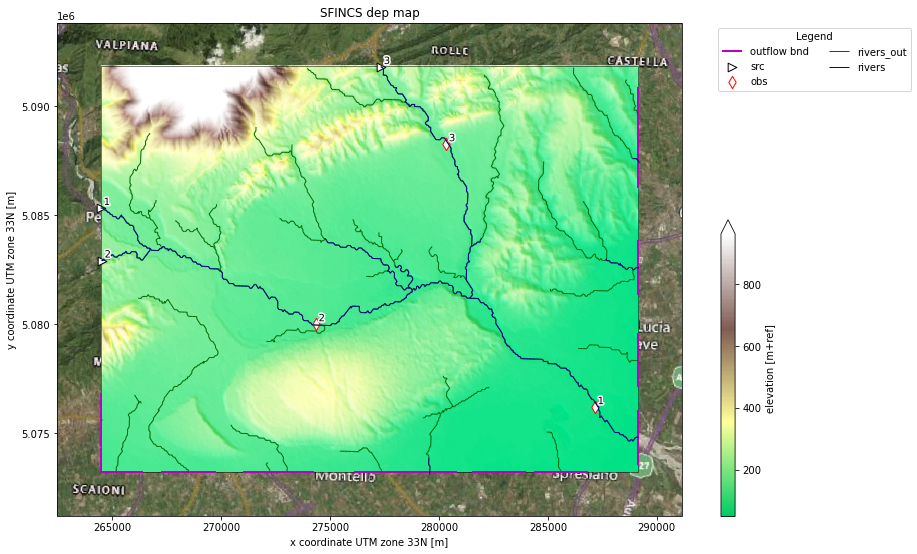

In [9]:
mod.plot_basemap(geoms=['src', 'obs', 'rivers_out', 'rivers'], figsize=(14, 14*0.65), legend_kwargs=dict(ncol=2))

(<Figure size 432x216 with 1 Axes>,
 [<AxesSubplot:title={'center':'SFINCS discharge forcing (dis)'}, ylabel='discharge\n[m3.s-1]'>])

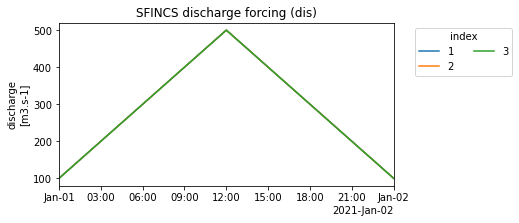

In [10]:
mod.plot_forcing()